In [1]:
import openturns as ot

In [2]:
ot.RandomGenerator.SetSeed(0)
dimension = 2
input_names = ['x1', 'x2']
formulas = ['cos(x1 + x2)', '(x2 + 1) * exp(x1)']
model = ot.SymbolicFunction(input_names, formulas)

In [11]:
model

class=SymbolicFunction name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x1,x2,y0,y1] evaluationImplementation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x1,x2] outputVariablesNames=[y0,y1] formulas=[cos(x1 + x2),(x2 + 1) * exp(x1)] gradientImplementation=class=SymbolicGradient name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x1,x2] outputVariablesNames=[y0,y1] formulas=[cos(x1 + x2),(x2 + 1) * exp(x1)] hessianImplementation=class=SymbolicHessian name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x1,x2] outputVariablesNames=[y0,y1] formulas=[cos(x1 + x2),(x2 + 1) * exp(x1)]

In [3]:
distribution = ot.Normal(dimension)
samplesize = 100
inputSample  = distribution.getSample(samplesize)
outputSample = model(inputSample)

In [4]:
ot.ResourceMap.SetAsUnsignedInteger("FittingTest-KolmogorovSamplingSize", 100)
algo = ot.FunctionalChaosAlgorithm(inputSample, outputSample)
algo.run()
result = algo.getResult()
metamodel = result.getMetaModel()

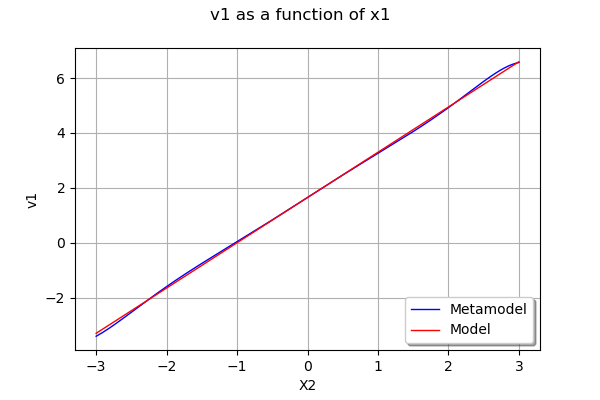

In [5]:
x1index = 0
x1value = 0.5
x2min = -3.
x2max = 3.
outputIndex = 1
metamodelParametric = ot.ParametricFunction(metamodel, [x1index], [x1value])
graph = metamodelParametric.getMarginal(outputIndex).draw(x2min, x2max)
graph.setLegends(["Metamodel"])
modelParametric = ot.ParametricFunction(model, [x1index], [x1value])
curve = modelParametric.getMarginal(outputIndex).draw(x2min, x2max).getDrawable(0)
curve.setColor('red')
curve.setLegend("Model")
graph.add(curve)
graph.setLegendPosition("bottomright")
graph.setXTitle("X2")
graph

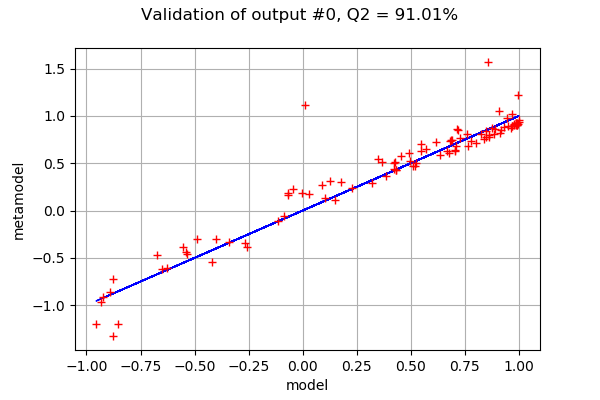

In [7]:
n_valid = 100
inputTest = distribution.getSample(n_valid)
outputTest = model(inputTest)

def drawValidation(inputTest,outputTest,metamodel,outputIndex):
    val = ot.MetaModelValidation(inputTest, outputTest[:,outputIndex],
                                 metamodel.getMarginal(outputIndex))
    Q2 = val.computePredictivityFactor()
    graph = val.drawValidation()
    graph.setTitle("Validation of output #%d, Q2 = %.2f%%" %
                   (outputIndex,Q2*100))
    graph.setLegends([""])
    return graph

outputIndex = 0
drawValidation(inputTest,outputTest,metamodel,outputIndex)

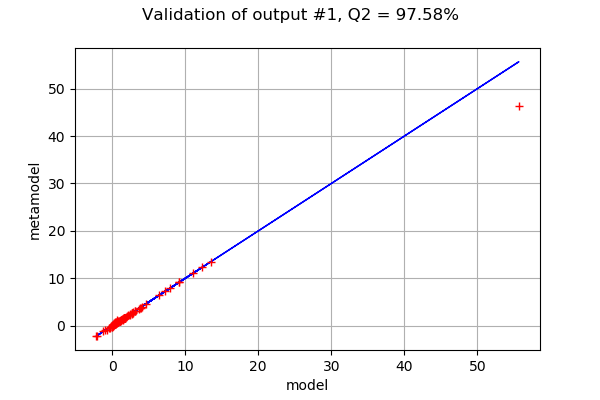

In [10]:
outputIndex = 1
drawValidation(inputTest,outputTest,metamodel,outputIndex)

In [6]:
chaosSI = ot.FunctionalChaosSobolIndices(result)
print(chaosSI.summary())

 input dimension: 2
 output dimension: 2
 basis size: 17
 mean: [0.364321,1.46479]
 std-dev: [0.742595,4.46299]
------------------------------------------------------------
Marginal: 0
Index   | Multi-indice                  | Part of variance  
------------------------------------------------------------
      6 | [1,1]                         | 0.308586
     12 | [3,1]                         | 0.213701
     14 | [2,2]                         | 0.173489
      4 | [0,2]                         | 0.169134
      3 | [2,0]                         | 0.134698
------------------------------------------------------------


------------------------------------------------------------
Component | Sobol index            | Sobol total index      
------------------------------------------------------------
        0 | 0.134698               | 0.830473              
        1 | 0.169527               | 0.865302              
------------------------------------------------------------

Marginal: 

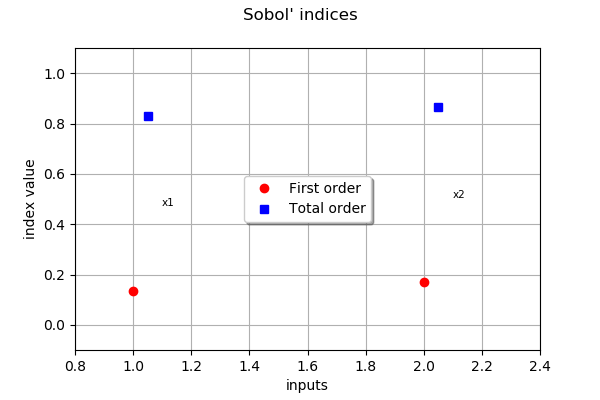

In [8]:
sensitivityAnalysis = ot.FunctionalChaosSobolIndices(result)
first_order = [sensitivityAnalysis.getSobolIndex(i) for i in range(dimension)]
total_order = [sensitivityAnalysis.getSobolTotalIndex(i) for i in range(dimension)]
input_names = model.getInputDescription()
graph = ot.SobolIndicesAlgorithm.DrawSobolIndices(input_names, first_order, total_order)
graph.setLegendPosition("center")
graph

In [9]:
ot.ResourceMap.GetAsUnsignedInteger("FunctionalChaosAlgorithm-MaximumTotalDegree")

10

In [10]:
degrees = ot.Sample([[i] for i in range(5,15)])
numberOfDegrees = degrees.getSize()
coefficientOfPredictivity = ot.Sample(numberOfDegrees,2)
for maximumDegree in range(5,15):
    ot.ResourceMap.SetAsUnsignedInteger(
        "FunctionalChaosAlgorithm-MaximumTotalDegree",
        maximumDegree)
    print("Maximum total degree =", maximumDegree)
    algo = ot.FunctionalChaosAlgorithm(inputSample, outputSample)
    algo.run()
    result = algo.getResult()
    metamodel = result.getMetaModel()
    for outputIndex in range(2):
        val = ot.MetaModelValidation(inputTest,
                                     outputTest[:,outputIndex],
                                     metamodel.getMarginal(outputIndex))
        Q2 = val.computePredictivityFactor()
        coefficientOfPredictivity[maximumDegree-5,outputIndex] = Q2

Maximum total degree = 5
Maximum total degree = 6
Maximum total degree = 7
Maximum total degree = 8
Maximum total degree = 9
Maximum total degree = 10
Maximum total degree = 11
Maximum total degree = 12
Maximum total degree = 13
Maximum total degree = 14


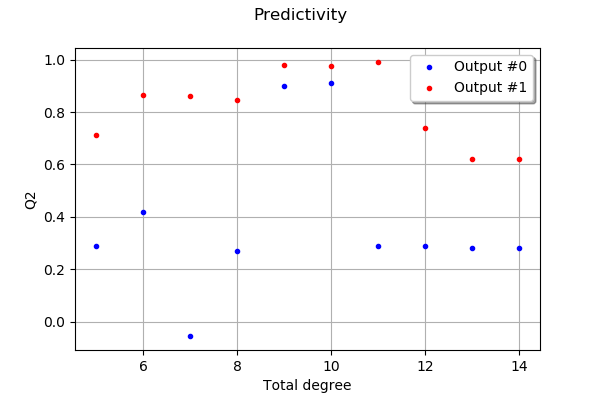

In [11]:
graph = ot.Graph("Predictivity","Total degree","Q2",True)
cloud = ot.Cloud(degrees,coefficientOfPredictivity[:,0])
cloud.setLegend("Output #0")
cloud.setPointStyle("bullet")
graph.add(cloud)
cloud = ot.Cloud(degrees,coefficientOfPredictivity[:,1])
cloud.setLegend("Output #1")
cloud.setColor("red")
cloud.setPointStyle("bullet")
graph.add(cloud)
graph.setLegendPosition("topright")
graph